### Training with DP-SGD using Opacus

In this notebook, we'll explore using DP-SGD using the Opacus library from Meta/PyTorch!

The problem we will try to solve is determining the review score from looking at a Steam review. The dataset can be [downloaded from Kaggle here](https://www.kaggle.com/datasets/luthfim/steam-reviews-dataset?resource=download). This dataset has not gone through any privacy-preserving preprocessing (like many datasets we can find on Kaggle and in other machine learning communities)!

We would like to use a BERT base and fine-tune it using Opacus to add differential privacy.

This notebook is based on the [tutorial notebook from Opacus](https://opacus.ai/tutorials/building_text_classifier). They also have other tutorials available for tasks like image recognition and recommendors!

In [1]:
import pandas as pd
import numpy as np
import torch
import transformers

from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers.data.processors.utils import InputExample
from transformers.data.processors.glue import glue_convert_examples_to_features
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification
from datasets import Dataset

from opacus import PrivacyEngine
from opacus.utils.uniform_sampler import UniformWithReplacementSampler
from opacus.utils.batch_memory_manager import BatchMemoryManager

First we need to get BERT and set what layers we actually want to train with.

In [2]:

model_name = "bert-base-cased"
config = BertConfig.from_pretrained(
    model_name,
    num_labels=3,
)
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-cased",
    do_lower_case=False,
    padding=True,
)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    config=config,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [3]:
trainable_layers = [model.bert.encoder.layer[-1], model.bert.pooler, model.classifier]
total_params = 0
trainable_params = 0

for p in model.parameters():
        p.requires_grad = False
        total_params += p.numel()

for layer in trainable_layers:
    for p in layer.parameters():
        p.requires_grad = True
        trainable_params += p.numel()

print(f"Total parameters count: {total_params}") # ~108M
print(f"Trainable parameters count: {trainable_params}") # ~7M


Total parameters count: 108312579
Trainable parameters count: 7680771


Next, let's take a look at the distribution of labels in our dataset.

In [4]:
df = pd.read_csv('data/steam_reviews.csv')
df.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


In [5]:
df.recommendation.value_counts()

Recommended        303593
Not Recommended    131298
Name: recommendation, dtype: int64

In [6]:
df['labels'] = df.recommendation.map(lambda x: 1 if x=='Recommended' else 0)

So we have a fairly significant skew in this set to recommend, let's hope we can still find some useful information! 

We also need to tell PyTorch the max string length for the review to appropriately use the transformer. Once we have that, we can start training!

In [7]:
df.review = df.review.fillna('')
df['review_len'] = df.review.map(len)

<AxesSubplot:>

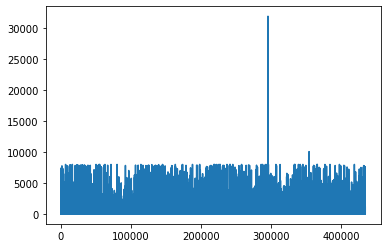

In [8]:
df['review_len'].plot()

Houston, we have a problem, let's try to fix our outliers...

In [9]:
df[df['review_len'] > 10000]['review']

295854    Battlegrounds&gt &gt &gt &gt &gt &gt &gt &gt &...
354570    Solo&gt All Map&gt Play&gt Wating other player...
Name: review, dtype: object

In [10]:
df.review = df.review.str.replace('&gt', '')

<AxesSubplot:>

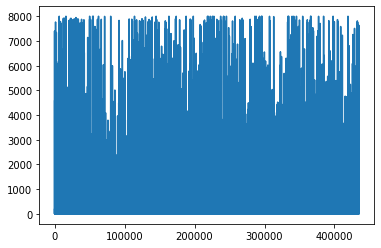

In [11]:
df['review_len'] = df.review.map(len)
df['review_len'].plot()

In [12]:
df.to_csv('data/stream_cleaned.csv')

In [13]:
df['labels'] = df.recommendation.map(lambda x: 1 if x == 'Recommended' else 0)
train_df = df.sample(frac=0.8,random_state=0)
test_df = df.drop(train_df.index)

Great, now we can set our max and move along!

Depending on your computer, you might want to start running the next few cells and go make some tea, drink some water, do 10 minutes of yoga/stretches or get some fresh air. It will take a minute to run.

In [14]:
MAX_SEQ_LENGTH = 1000

In [15]:
train_ds = Dataset.from_pandas(train_df[['review', 'labels']])
test_ds = Dataset.from_pandas(test_df[['review', 'labels']])

In [16]:
def tokenization(example):
    return tokenizer(example["review"], padding=True, truncation=True)

train_tok = train_ds.map(tokenization, batched=True)

  0%|          | 0/348 [00:00<?, ?ba/s]

In [17]:
test_tok = test_ds.map(tokenization, batched=True)

  0%|          | 0/87 [00:00<?, ?ba/s]

In [18]:
train_tok.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
test_tok.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])

In [19]:
train_tok = train_tok.remove_columns(['review'])
test_tok = test_tok.remove_columns(['review'])

In [20]:
BATCH_SIZE = 32
MAX_PHYSICAL_BATCH_SIZE = 8

In [21]:
train_dataloader = DataLoader(train_tok, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_tok, sampler=SequentialSampler(test_tok), batch_size=BATCH_SIZE)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to train mode (HuggingFace models load in eval mode)
model = model.train()
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=1e-8)

In [23]:
EPOCHS = 3
LOGGING_INTERVAL = 5000 # once every how many steps we run evaluation cycle and report metrics
EPSILON = 7.5
DELTA = 1 / len(train_dataloader) # Parameter for privacy accounting. Probability of not achieving privacy guarantees

In [24]:

def accuracy(preds, labels):
    return (preds == labels).mean()

# define evaluation cycle
def evaluate(model):    
    model.eval()

    loss_arr = []
    accuracy_arr = []
    
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            print(batch[0], batch[1])
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],
                      'labels':         batch[3]}

            outputs = model(**inputs)
            loss, logits = outputs[:2]
            
            preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
            labels = inputs['labels'].detach().cpu().numpy()
            
            loss_arr.append(loss.item())
            accuracy_arr.append(accuracy(preds, labels))
    
    model.train()
    return np.mean(loss_arr), np.mean(accuracy_arr)

In [25]:

MAX_GRAD_NORM = 0.1

privacy_engine = PrivacyEngine()

model, optimizer, train_dataloader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    target_delta=DELTA,
    target_epsilon=EPSILON, 
    epochs=EPOCHS,
    max_grad_norm=MAX_GRAD_NORM,
)

/home/katharine/.virtualenvs/py3data/lib/python3.8/site-packages/opacus/privacy_engine.py:133: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/katharine/.virtualenvs/py3data/lib/python3.8/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


In [27]:
for epoch in range(1, EPOCHS+1):
    losses = []

    with BatchMemoryManager(
        data_loader=train_dataloader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
        for step, batch in enumerate(tqdm(memory_safe_data_loader)):
            optimizer.zero_grad()
            
            print(type(batch))
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2],
                    'labels':         batch[3]}

            outputs = model(**inputs) # output = loss, logits, hidden_states, attentions

            loss = outputs[0]
            loss.backward()
            losses.append(loss.item())

            optimizer.step()

            if step > 0 and step % LOGGING_INTERVAL == 0:
                train_loss = np.mean(losses)
                eps = privacy_engine.get_epsilon(DELTA)

                eval_loss, eval_accuracy = evaluate(model)

                print(
                  f"Epoch: {epoch} | "
                  f"Step: {step} | "
                  f"Train loss: {train_loss:.3f} | "
                  f"Eval loss: {eval_loss:.3f} | "
                  f"Eval accuracy: {eval_accuracy:.3f} | "
                  f"ɛ: {eps:.2f}"
                )


  0%|          | 0/43489 [00:00<?, ?it/s]

<class 'dict'>


AttributeError: 'str' object has no attribute 'to'